In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [10]:
from numpy.typing import NDArray, DTypeLike
from typing import Literal, Tuple, List, Optional

In [9]:
def sigmoid(z: NDArray):
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
class MNIST_DATASET:
    splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
    
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df 
    
    def get_sample(self, index: int, normalize: bool = False, normalized_dtype: DTypeLike = np.float16):
        img = MNIST_DATASET._get_image(self.df, index)
        if normalize:
            img = MNIST_DATASET._normalize(img, dtype=normalized_dtype)
        return (img, self.df.loc[index]['label'])
    
    def imshow(
        self, 
        index: int, 
        figsize: Tuple[int, int] = (6, 6), 
    ):
        img = MNIST_DATASET._get_image(self.df, index)

        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
        plt.show()
    
    def __len__(self) -> int:
        return len(self.df)
    
    @staticmethod
    def get_split(split: Literal['train', 'test']):
        return MNIST_DATASET(pd.read_parquet("hf://datasets/ylecun/mnist/" + MNIST_DATASET.splits[split]))
    
    @staticmethod
    def _get_image(df: pd.DataFrame, index: int):
        return np.array(Image.open(BytesIO(df.loc[index]['image']['bytes'])), np.uint8)
    
    @staticmethod
    def _normalize(img: NDArray, dtype: DTypeLike = np.float16):
        return (img / 255).astype(dtype)

In [11]:
class Network:
    def __init__(self, sizes: List[int]) -> None:
        self.sizes = sizes
        self.n_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [
            np.random.randn(y, x)
            for x, y in zip(sizes[:-1], sizes[1:])
        ]
        
    def feedforward(self, a: NDArray) -> NDArray:
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(
            self, 
            training_data: NDArray, 
            epochs: int, 
            mini_batch_size: int, 
            lr: float,
            test_data: Optional[NDArray] = None
        ):
        for i in range(epochs):
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j: j + mini_batch_size] 
                self.update_mini_batch(mini_batch, lr)
            
            if test_data is not None:
                print(f'Epoch: {i}: {self.evaluate(test_data)} / {len(test_data)}')
            else:
                print(f'Epoch {i} complete')

    def update_mini_batch(self, mini_batch: NDArray, lr: float):
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]

        for x, y in mini_batch:
            pass

    def evaluate(self, data: NDArray) -> int:
        test_results = [
            np.argmax(self.feedforward(x)) == y
            for x, y in data
        ]
        
        return sum(test_results)

In [5]:
train_dataset = MNIST_DATASET.get_split('train')
test_dataset = MNIST_DATASET.get_split('test')

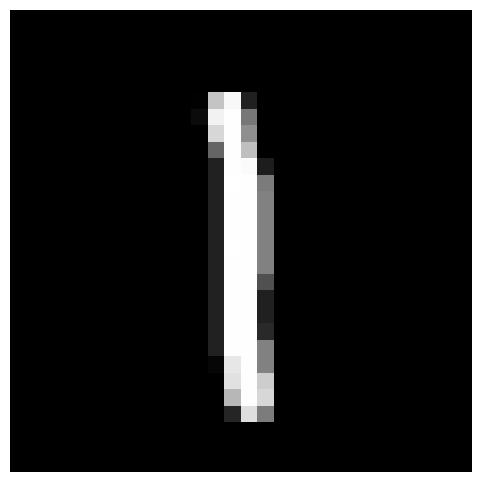

In [6]:
train_dataset.imshow(14)

## Exercises

1. __Sigmoid neurons simulating perceptrons, part I__: Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, $c > 0$. Show that the behaviour of the network doesn't change. 

    `Ans:`
     
    \begin{align*}
        (c \times w) \cdot x + c \times b   &= c \times (w \cdot x) + c \times b \\
                                            &= c \times (w \cdot x + b)
                                            \\
        \text{For a perceptron,} \\
                                    output =& \begin{cases}
                                            0    & w \cdot x + b \leq 0 \\
                                            1    & w \cdot x + b > 0
                                            \end{cases} \\
                                            \\
        \text{When, } w \cdot x + b         &\leq 0 \\
        \text{For some positive constant } c, \\
            c \times (w \cdot x + b)        &\leq 0 \\
                                            \\
        \text{Similarly,} \\
        \text{When, } w \cdot x + b         &> 0 \\
         c \times (w \cdot x + b)           &> 0 \\
    \end{align*}

2. __Sigmoid neurons simulating perceptrons, part II__: Suppose we have the same setup as the last problem - a network of perceptrons. Suppose also that the overall input to the network of perceptrons has been chosen. We won't need the actual input value, we just need the input to have been fixed. Suppose the weights and biases are such that $w \cdot x + b \neq 0$ for the input $x$ to any particular perceptron in the network. Now replace all the perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant $c > 0$. Show that in the limit as $c \rightarrow \infty$ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons. How can this fail when $w \cdot x + b = 0$ for one of the perceptrons? 

    `Ans:`

    \begin{align*}
        \text{For } w \cdot x + b > 0, \\
        \lim_{c \rightarrow \infty} c \times (w \cdot x + b)    &= +\infty
                                                                \\ \\
        \text{For } w \cdot x + b < 0, \\
        \lim_{c \rightarrow \infty} c \times (w \cdot x + b)    &= -\infty 
                                                                \\ \\
        \text{The output of the sigmoid neuron is given by,} \\
                                                    \sigma      &= \frac{1}{1 + e^{-z}} \quad [z = w \cdot x + b]
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= +\infty \\
                                                    \sigma      &= \frac{1}{1 + e^{-\infty}} \quad \\
                                                                &= \frac{1}{1 + 0} \quad \\
                                                                &= 1
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= -\infty \\
                                                    \sigma      &= \frac{1}{1 + e^{\infty}} \quad \\
                                                                &= \frac{1}{\infty} \quad \\
                                                                &= 0
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= 0 \\
                                                    \sigma      &= \frac{1}{1 + e^{0}} \quad \\
                                                                &= \frac{1}{1 + 1} \quad \\
                                                                &= 0.5 \quad \text{[which is not a valid value for a perceptron]}
    \end{align*}

3. There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least 0.99, and incorrect outputs have activation less than 0.01. 

<div style='background-color: #ffffff; display: flex; justify-content: center; padding-bottom: 8px'>
    <img src='other-assets/tikz13.png' />
</div>

`Ans:` Assuming $0.99$ is activation for the correct neuron and $0.009$ is activation for the incorrect neurons.

\begin{align*}
    \text{Weights, }    w^{(O)} &= \begin{bmatrix}
        -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & 0.1 & 0.09 \\
        -0.5 & -0.5 & -0.5 & -0.5 & 0.1 & 0.07 & 0.05 & 0.1 & -0.5 & -0.5 \\
        -0.5 & -0.5 & 0.09 & 0.1 & -0.5 & -0.5 & 0.1 & 0.04 & -0.5 & -0.5 \\
        -0.5 & -0.5 & -0.5 & 0.04 & -0.5 & 0.04 & -0.5 & 0.07 & -0.5 & 0.1         
    \end{bmatrix} 
    \\
    \text{Biases, }     b^{(O)} &= \begin{bmatrix}
        0 & 0 & 0 & 0
    \end{bmatrix}^T
    \\
    \text{Input activations, } a^{(I)} &= \begin{bmatrix}
        a_0^{(I)} & a_1^{(I)} & a_2^{(I)} & a_3^{(I)} & a_4^{(I)} & a_5^{(I)} & a_6^{(I)} & a_7^{(I)} & a_8^{(I)} & a_9^{(I)}
    \end{bmatrix}^T
    \\
        z &= w^{(O)} a^{(I)} + b^{(O)}
    \\
    \text{Output, } O_i &= \begin{cases}
    0   &   \sigma(z_i) < 0.5 \\
    1   &   \sigma(z_i) \geq 0.5 \\
    \end{cases}
\end{align*}

4. An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, x, we update our weights and biases according to the rules $wk \rightarrow w'_{k}=w_k − \eta \frac{\partial C_x}{\partial w_k}$ and $b_l \rightarrow b'_{l}=b_l − \eta \frac{\partial C_x}{\partial b_l}$. Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20. 

    `Ans:`
    
    Advantage: Faster weight updates as new data come.
    
    Disadvantage: Update based on a mini-batch could be noisy resulting into a performance degradation. 

### Notations:

- Weight from $k^{th}$ neuron in the $(l-1)^{th}$ layer to the $j^{th}$ neuron in the $l^{th}$ layer: $w_{jk}^l$
- Bias for the $j^{th}$ neuron in the $l^{th}$: $b_j^l$
- Activation at the $j^{th}$ neuron in $l^{th}$ layer: $a_j^l = \sigma{(\sum_{k} w_{jk}^l a_k^{l-1} + b_j^l)}$

### Matrix Form:
- Weights in the $l^{th}$ layer: $w^l = \begin{bmatrix} 
    w_{00}^l & w_{01}^l & w_{02}^l & \cdots & w_{0k}^l \\
    w_{10}^l & w_{11}^l & w_{12}^l & \cdots & w_{1k}^l \\
    w_{20}^l & w_{21}^l & w_{22}^l & \cdots & w_{2k}^l \\
    \vdots  &   \vdots  &   \vdots  & \ddots  &   \vdots \\
    w_{j0}^l & w_{j1}^l & w_{j2}^l & \cdots & w_{jk}^l \\
\end{bmatrix}_{j \times k}$
- Biases in the $l^{th}$ layer: $b^l = \begin{bmatrix} b_0^l \\ b_1^l \\ b_2^l \\ \vdots \\ b_k^l \end{bmatrix}$
- Activations in the $l^{th}$ layer: $a^l = \sigma(w^l a^{l-1} + b^l)$